In [255]:
import numpy as np
from scipy.stats import zscore
import networkx as nx
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
import itertools
import matplotlib.pyplot as plt
%run load_nc_and_subset.ipynb
%matplotlib notebook

In [256]:
def get_cross_entropy(p, y):
    p, y = np.squeeze(p), np.squeeze(y)
    return (-1/y.shape[0]) * np.sum(y*np.log(p+1E-6) + (1-y)*np.log(1-p+1E-6))

def get_mean_squared_error(p, y):
    p, y = np.squeeze(p), np.squeeze(y)
    return (1/y.shape[0]) * np.sum((y-p)**2)

def get_r_squared_score(p, y):
    p, y = np.squeeze(p), np.squeeze(y)
    yb = np.sum(y)/y.shape[0]
    sstot = np.sum((y-yb)**2)
    ssres = np.sum((y-p)**2)
    return 1 - ssres/sstot

# Validate custom MSE and R2 computation functions
np.random.seed(0)
tp, ty = np.random.rand(10), np.random.rand(10)
assert(mean_squared_error(tp, ty)==get_mean_squared_error(tp, ty)), 'MSE does not match ground truth!'
assert(get_r_squared_score(tp, ty)==r2_score(ty, tp)), 'R2 does not match ground truth!'

# Neural Network

**Note**: gradient descent was implemented following [this guide](https://towardsdatascience.com/a-step-by-step-implementation-of-gradient-descent-and-backpropagation-d58bda486110) by Yitong Ren of Towards Data Science.

In [257]:
class Node:
    def __init__(self, activation_function=np.sign, coalescant_function=np.sum):
        self._coalescant_function = coalescant_function
        self._weight = 1
        self._activation_function = activation_function
        
    def __str__(self):
        return '[{} {} {}]'.format(
            self._coalescant_function.__name__, 
            self._weight, 
            self._activation_function.__name__
        )
    
    @property 
    def activation(self):
        return self._activation_function
    
    @property 
    def coalescant(self):
        return self._coalescant_function
    
    def propagate(self, tensor):
        return self.activation(
            self._weight * self.coalescant(tensor)
        ) 
    
class Layer:
    def __init__(self, network=None, nodes=0):
        self._nodes = {idx:Node() for idx in range(nodes)}
        self._network = network
        self._upstream = None
        self._downstream = None
    
    @property
    def node_keys(self):
        return list(self._nodes.keys())

    @property
    def nodes(self):
        return list(self._nodes.items())
    
    @property
    def downstream_nodes(self):
        return self.downstream.node_keys if self.downstream else None
    
    @property
    def upstream_nodes(self):
        return self.upstream.node_keys if self.upstream else None
    
    @property
    def downstream(self):
        return self._downstream
    
    @property
    def upstream(self):
        return self._upstream
    
    def build_connectivity(self):
        if self.upstream is None:
            connections= []
        else:
            connections = list(itertools.product(self.upstream_nodes,self.node_keys))
        return self.node_keys, connections
    

def keygen(layer, node, **kwargs):
    return 'layer{}:node{}'.format(layer,node)
    
class NeuralNetwork:
    def __init__(self, input_layer=None, output_layer=None):
        self._input_layer  = input_layer
        self._output_layer = output_layer
        self._layers = []
        self._weights = []
        self._connectivity = None
    
    @property
    def layers(self):
        return self._layers
    
    def add_layer(self, layer):
        layer.network = self
        self._layers.append(layer)
        
    def build_connectivity(self):
        self._weights = []
        self._connectivity = nx.Graph()
        all_layers = [self._input_layer] + self._layers + [self._output_layer]
        for idx, layer in enumerate(all_layers):
            layer._upstream = None if idx == 0 else all_layers[idx-1]
            layer._downstream = all_layers[idx+1] if idx+1 < len(all_layers) else None 
            if layer._upstream is not None:
                sx, sy = len(layer._upstream.node_keys), len(layer.node_keys)
                self._weights.append(
                    np.zeros((sx, sy))
                )
            nodes, connections = layer.build_connectivity()
            nodes = [keygen(idx,node) for node in nodes]
            connections = [(keygen(idx-1, nu), keygen(idx, nd)) for nu, nd in connections]
            self._connectivity.add_edges_from(connections)
        self._all_layers = all_layers
    
    def visualize(self):
        pos = {}
        for idx, layer in enumerate(self._all_layers):
            length = len(layer.nodes)
            y = np.arange(-length/2,length/2,1)            
            pos.update({keygen(idx,node):(idx,y[node]) for node in layer.node_keys})
        nx.draw(self._connectivity, pos=pos)
        plt.show()
    
    def initialize(self, seed=0):
        np.random.seed(seed)
        self.build_connectivity()
        for idx in range(len(self._weights)):
            self._weights[idx] = np.random.rand(*self._weights[idx].shape)
    
    def predict(self, X, return_partials=False):
        x = X
        Lx = []
        for w in self._weights:
            Lx.append(x)
            x = sigmoid(x, w)
            y_out = x
        if return_partials:
            return Lx, y_out
        else:
            return np.squeeze(y_out)
    
    def classify(self, X):
        y_out = self.predict(X)
        if y_out.ndim == 1 or y_out.shape[-1] == 1:
            classifications = np.round(np.clip(y_out,0,1)) 
        else:
            classifications = np.argmax(y_out,axis=1)
        return np.squeeze(classifications)
    
    def score(self, X, y):
        return np.sum(self.classify(X)==y)/y.shape[0]
    
    def gradient_descent(self, X, y, iterations):
        if y.ndim == 1:
            y = y.reshape((-1,1))
        
        wlid = np.identity(y.shape[-1])
        scores = np.zeros((iterations,))
        
        for i in range(iterations):
            Lx, y_out = self.predict(X, return_partials=True)
            
            lg = (y - y_out)
            wl = wlid
            Lgrad = []
            
            for idx, (lx, w) in enumerate(zip(Lx[::-1], self._weights[::-1])):
                delta = np.dot(lg, wl.T)
                lg = delta * sigmoid_derivative(lx, w)
                grad = np.dot(lx.T, lg)
                wl = w
                Lgrad.append(grad)
            
            for idx in range(len(self._weights)):
                self._weights[idx] = self._weights[idx] + Lgrad[-(idx+1)]
            
            scores[i] = self.score(X,y)
        return scores
    
def sigmoid(x, w):
    return 1/(1 + np.exp(-np.dot(x, w)))

def sigmoid_derivative(x, w):
    return sigmoid(x, w) * (1 - sigmoid(x, w))


# Verify Basic Operation

In [351]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
N = 100
M = 5
E = 10000
layer_sizes = (10,)

X, y_i = make_classification(
    n_samples=N, 
    n_features=M, 
    n_informative=M,
    n_redundant=0,
    n_classes=M, 
    random_state=1
)

y = np.zeros((M, N))
np.put_along_axis(y, y_i[np.newaxis, :], np.ones((N,)), axis=0)
y = y.T.reshape(N,M)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

clf = MLPClassifier(
    solver='sgd',
    hidden_layer_sizes=layer_sizes,
    random_state=0,
    max_iter=E
)
clf.fit(X_train, y_train)
clf.predict_proba(X_test[:1])
p = clf.predict(X)
clf.score(X_test, y_test)
default_params = clf.get_params()

<IPython.core.display.Javascript object>


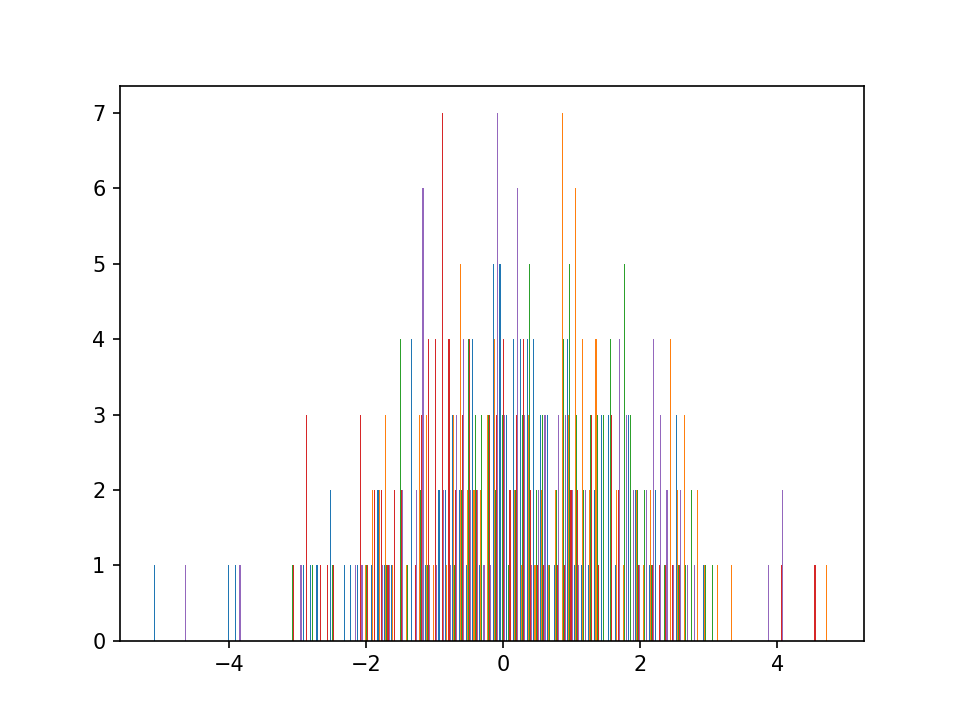

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 1., 1., 1., 0.,
         1., 2., 1., 1., 0., 0., 4., 0., 1., 0., 2., 2., 3., 2., 1., 4.,
         1., 0., 5., 5., 3., 4., 4., 4., 4., 3., 3., 1., 0., 4., 1., 1.,
         1., 2., 3., 3., 1., 0., 3., 2., 0., 1., 2., 0., 0., 3., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         2., 2., 3., 1., 0., 1., 0., 3., 3., 1., 0., 1., 3., 5., 2., 2.,
         2., 3., 4., 0., 0., 2., 1., 3., 1., 2., 1., 2., 7., 3., 6., 4.,
         2., 4., 0., 0., 2., 1., 0., 2., 1., 2., 0., 0., 4., 2., 3., 0.,
         2., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [352]:
plt.figure()
plt.hist(X, bins=100)

<IPython.core.display.Javascript object>


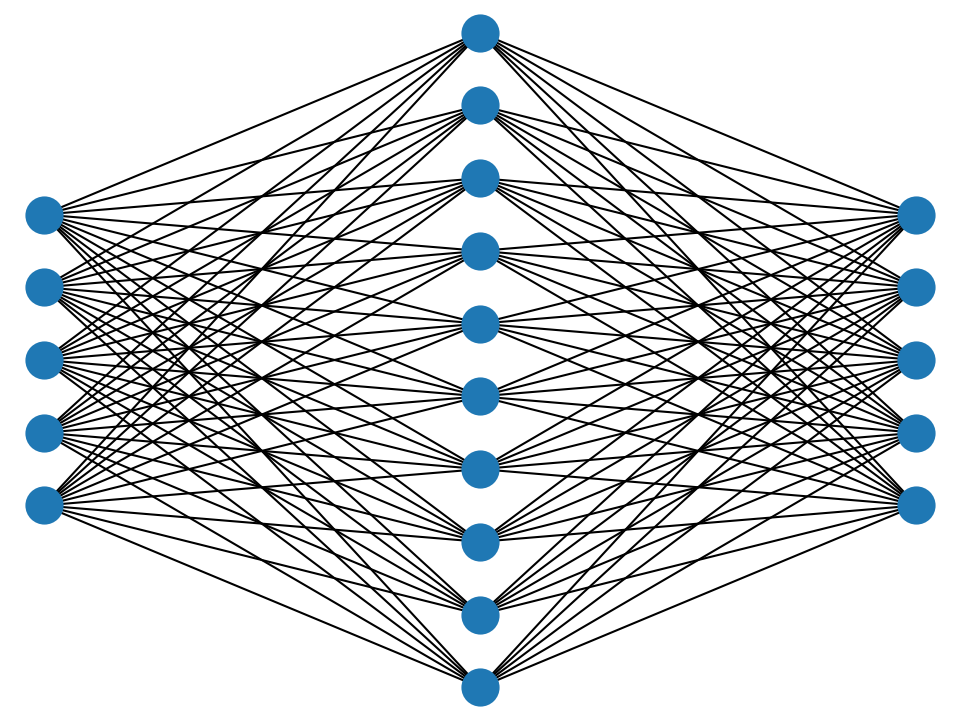

18


In [259]:
nn = NeuralNetwork(
    input_layer = Layer(nodes=(1 if (X.ndim == 1) else X.shape[-1])),
    output_layer = Layer(nodes=(1 if (y.ndim == 1) else y.shape[-1]))
)
layers = []
for s in layer_sizes:
    layer = Layer(nodes=s)
    nn.add_layer(layer)
    layers.append(s)
nn.initialize()
nn.visualize()
mse = nn.gradient_descent(
    X, 
    y, 
    E
)
print(np.sum(np.abs(nn.classify(X)-y_i)))

<IPython.core.display.Javascript object>


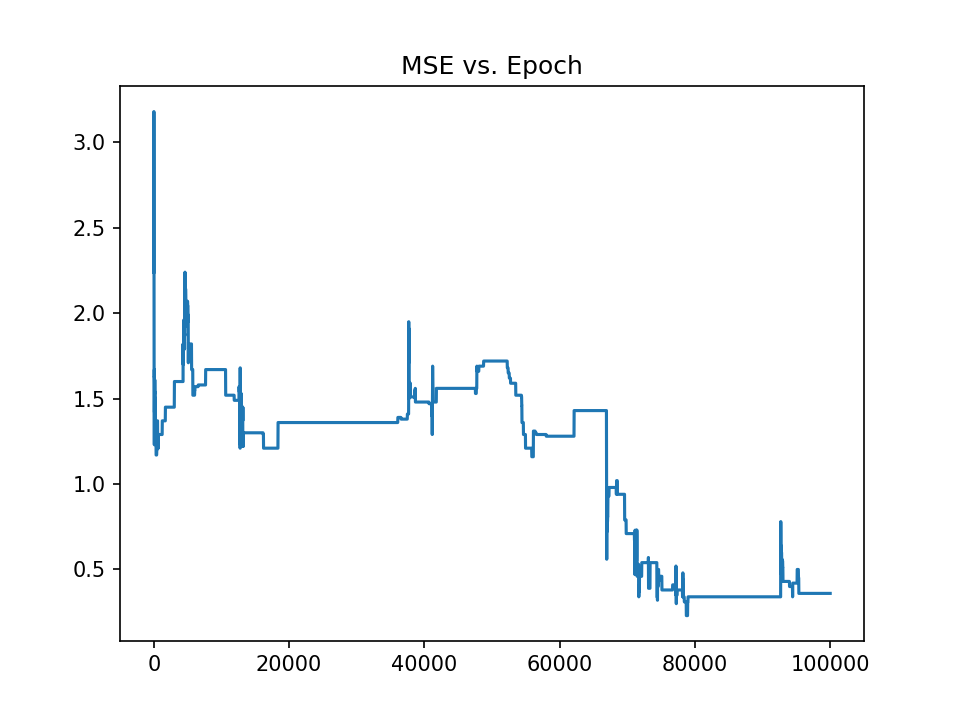

Text(0.5, 1.0, 'MSE vs. Epoch')

In [260]:
Np = 10000
idx = np.arange(0,E,np.ceil(1+E/Np)).astype(int)
plt.figure()
plt.plot(idx, mse[idx])
plt.title('MSE vs. Epoch')

In [397]:
N = 1000
M = 5
E = 1000

In [410]:
np.sum(spi_1d != 0)/spi_1d.size

0.6524183626841014

<IPython.core.display.Javascript object>


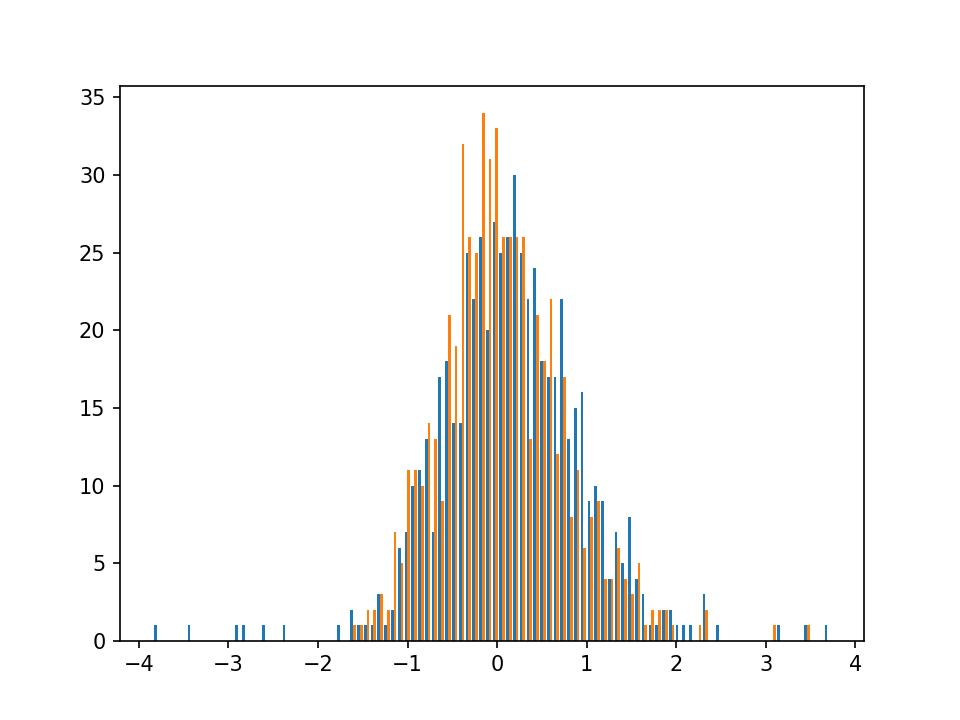

In [478]:
np.random.seed(0)

good = np.where(spi_1d != 0)[0]
spi_1d_g = spi_1d[good]
sesr_1d_g = sesr_1d[good]
usdm_1d_g = usdm_1d[good]

unused_indices = np.random.choice(usdm_1d_g.shape[0], min(N,usdm_1d_g.shape[0]), replace=False)
testing_i = np.random.choice(unused_indices, size=int(unused_indices.size*0.20), replace=False)
unused_indices = np.setdiff1d(unused_indices, testing_i)
training_i = np.random.choice(unused_indices, size=int(unused_indices.size*0.75), replace=False)
validation_i = np.setdiff1d(unused_indices, training_i)

def label_to_binary(labels, M=None):
    N = labels.shape[0]
    y_i = labels.astype(int)
    y = np.zeros((M, N))
    np.put_along_axis(y, y_i[np.newaxis, :], np.ones((N,)), axis=0)
    y = y.T.reshape(N,M)
    return y

ylabel = usdm_1d_g[training_i]
X = np.vstack((sesr_1d_g[training_i], spi_1d_g[training_i])).T
y = label_to_binary(ylabel, M=5)
y = np.any(y[:,1:],axis=1)

plt.figure()
plt.hist(X, bins=100);

In [480]:
clf = MLPClassifier(
    solver='sgd',
    random_state=0,
    max_iter=E
)
clf.fit(X, y)
y_p = clf.predict(X)
print(list(zip(*np.unique(y_p, return_counts=True))))
print(np.sum(y_p==y)/y.shape[0])
#unique, counts = np.unique(np.argmax(y_p,axis=1), return_counts=True)
#print(np.sum(np.any(y_p[:,1:],axis=1)==np.any(y[:,1:],axis=1))/y.shape[0])

[(False, 596), (True, 4)]
0.79


In [493]:
# Use hidden layer size predicted generated by scikit learn
layer_sizes = (10,)
E = 774
nn = NeuralNetwork(
    input_layer = Layer(nodes=(1 if (X.ndim == 1) else X.shape[-1])),
    output_layer = Layer(nodes=(1 if (y.ndim == 1) else y.shape[-1]))
)
layers = []
for s in layer_sizes:
    layer = Layer(nodes=s)
    nn.add_layer(layer)
    layers.append(s)
nn.initialize()
mse = nn.gradient_descent(X, y, E)

y_p = nn.classify(X)
print(list(zip(*np.unique(y_p, return_counts=True))))
print(np.sum(y_p==y)/y.shape[0])

# unique, counts = np.unique(y_p, return_counts=True)
# print(list(zip(unique,counts)))
# print(np.sum(y_p==np.any(y[:,1:],axis=1))/y.shape[0])

[(0.0, 598), (1.0, 2)]
0.7833333333333333


<IPython.core.display.Javascript object>


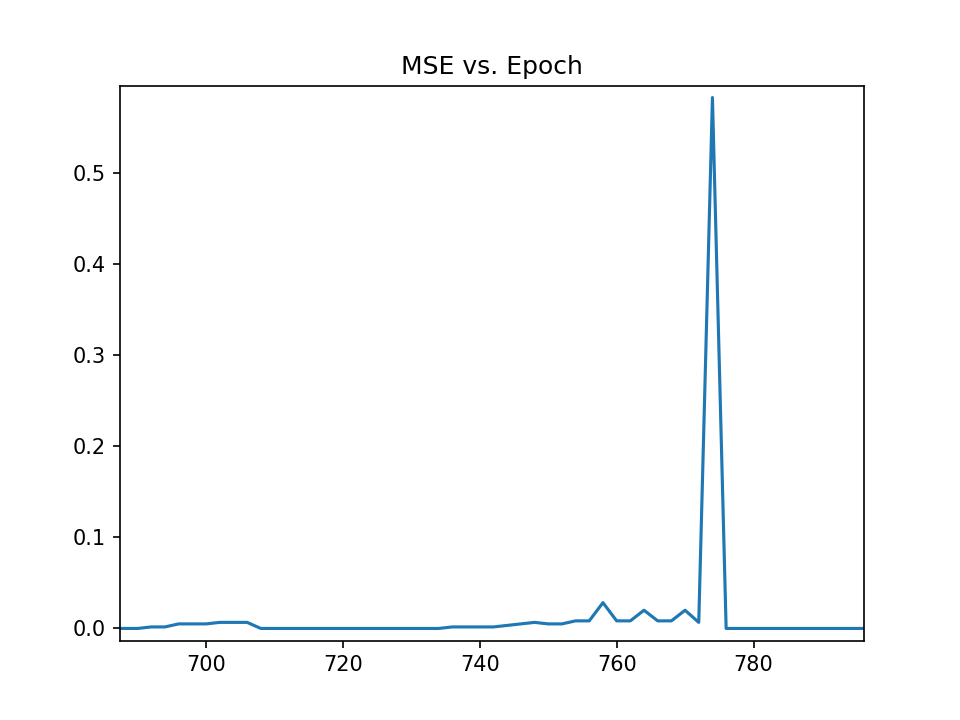

In [492]:
Np = 10000
idx = np.arange(0,E,np.ceil(1+E/Np)).astype(int)
plt.figure()
plt.plot(idx, mse[idx])
plt.title('MSE vs. Epoch')
plt.show()